source: [LangGraph Deep Dive: Build Better Agents](https://www.youtube.com/watch?v=usOmwLZNVuM) (YouTube Video, Channel: James Briggs)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# GPT-4o Research Agent in LangGraph

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing. Most research agents are packed up into their own frameworks, like BlockAGI and others.

In this example, we want to demonstrate how we can build our own AI research agent using `gpt-4o`, Pinecone, LangGraph, arXiv, and Google via the SerpAPI.

In [7]:
!apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-7+deb12u1).
libgraphviz-dev is already the newest version (2.42.2-7+deb12u1).
pkg-config is already the newest version (1.8.1-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

Now we install Python libraries:

In [9]:
!pip install -qU \
    datasets==2.19.1 \
    langchain-pinecone==0.1.1 \
    langchain-openai==0.1.9 \
    langchain==0.2.5 \
    langchain-core==0.2.9 \
    langgraph==0.1.1 \
    semantic-router==0.0.48 \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pygraphviz==1.11  # for visualizing

In [15]:
!pip install -qU \
    datasets==2.19.1 \
    langchain-pinecone==0.1.1 \
    langchain-openai==0.1.9 \
    langchain==0.2.5 \
    langchain-core==0.2.9 \
    langgraph==0.1.1 \
    semantic-router==0.0.48 \
    cohere==5.3.1 \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pygraphviz==1.11

## Research Agent Overview

Our research agent will consist of a function calling AI agent that has access to several tools that it can use to find information on a particular topic. It will be able to use several tools over multiple steps, meaning it can find information on one topic, broaden the scope of knowledge on this topic and _even_ investigate parallel topics where relevant.

The tools we will be using are:

* **ArXiv paper fetch**: Given an arXiv paper ID, this tool provides our agent with the abstract of the paper.
* **Web search**: This tool provides our agent with access to Google search for more generalized queries.
* **RAG search**: We will create a knowledge base containing AI arXiv papers. This tool provides our agent with access to this knowledge.
* **RAG search with filter**: Sometimes our agent may need more information from a specific paper, this tool allows our agent to do just that.
* **Final answer**: We create a custom final answer tool that forces our agent to output information in a specific format like:

```
INTRODUCTION
------------
<some intro to our report>

RESEARCH STEPS
--------------
<the steps the agent took during research>

REPORT
------
<the report main body>

CONCLUSION
----------
<the report conclusion>

SOURCES
-------
<any sources the agent used>
```

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

The first thing we need for an agent using RAG is somewhere we want to pull knowledge from. We will use v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

Note: we're using the prechunked dataset. For the raw version see [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2).

In [1]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 209760/209760 [00:01<00:00, 195538.87 examples/s]


Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [2]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

Building a knowledge base:

In [12]:
# !pip install cohere==4.10.0
!pip install "cohere>=5.0,<5.5"

INFO: pip is looking at multiple versions of botocore to determine which version is compatible with other requirements. This could take a while.
  Using cached types_requests-2.32.0.20250328-py3-none-any.whl.metadata (2.3 kB)
INFO: pip is still looking at multiple versions of botocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.4.0
    Uninstalling urllib3-2.4.0:
      Successfully uninstalled urllib3-2.4.0
  Attempting uninstall: types-requests
    Found exi

In [20]:
import os
from getpass import getpass
# from semantic_router.encoders import OpenAIEncoder
from semantic_router.encoders.openai import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

OpenAI API key:  ········


In [21]:
!cat /usr/local/lib/python3.9/site-packages/semantic_router/encoders/__init__.py

from typing import List, Optional

from semantic_router.encoders.base import BaseEncoder
from semantic_router.encoders.bedrock import BedrockEncoder
from semantic_router.encoders.bm25 import BM25Encoder
from semantic_router.encoders.clip import CLIPEncoder
#from semantic_router.encoders.cohere import CohereEncoder
from semantic_router.encoders.fastembed import FastEmbedEncoder
from semantic_router.encoders.google import GoogleEncoder
from semantic_router.encoders.huggingface import HuggingFaceEncoder
from semantic_router.encoders.huggingface import HFEndpointEncoder
from semantic_router.encoders.mistral import MistralEncoder
from semantic_router.encoders.openai import OpenAIEncoder
from semantic_router.encoders.tfidf import TfidfEncoder
from semantic_router.encoders.vit import VitEncoder
from semantic_router.encoders.zure import AzureOpenAIEncoder
from semantic_router.schema import EncoderType

__all__ = [
    "BaseEncoder",
    "AzureOpenAIEncoder",
    "CohereEncoder",
    "OpenAIEnc

In [22]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key)

Pinecone API key:  ········


In [26]:
from pinecone import ServerlessSpec

# spec = ServerlessSpec(
#     cloud="aws", region="us-west-2"  # us-east-1
# )

spec = ServerlessSpec(
    cloud='aws',       # or 'gcp' if needed
    region='us-east-1' # <-- supported for free tier
)

In [27]:
dims = len(encoder(["some random text"])[0])
dims

1536

In [28]:
import time

index_name = "gpt-4o-research-agent"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=dims,  # dimensionality of embed 3
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

Populate our knowledge base:

In [29]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:10000]

batch_size = 128

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    # get batch of data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["arxiv_id"],
        "references": r["references"].tolist()
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    # get text content to embed
    content = [r["content"] for r in batch]
    # embed text
    embeds = encoder(content)
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

100%|██████████| 79/79 [14:17<00:00, 10.85s/it]


## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [30]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### ArXiv Paper Fetch

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [31]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [32]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [33]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [34]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [35]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]

SerpAPI key:  ········


In [36]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [37]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted, ground coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans, ...
https://en.wikipedia.org/wiki/Coffee
---
Huge coffee company files for bankruptcy protection
U.S.-based Montesanto affiliate Ally Coffee, a green coffee importer, was not included in the bankruptcy filing, according to Daily Coffee News.
https://www.thestreet.com/retail/huge-coffee-company-files-for-bankruptcy-protection
---
Buy Coffee, Tea, Powders Online | The Coffee Bean & Tea ...
Buy exceptional coffee, tea, powders, equipment and drinkware at The Coffee Bean & Tea Leaf® online store to enjoy our globally sourced products at home.
https://www.coffeebean.com/
---
Peet's Coffee | The Original Craft Coffee Since 1966
Since 1966, Peet's Coffee has sourced and offered superior coffees and teas adhered to strict high-quality and taste standards. Shop online today.
https://www.peets.com/
---
Starbucks Coffee Company
More than jus

We put this process into a tool:

In [38]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

### RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [39]:
from langchain_core.tools import tool

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [40]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [41]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [42]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

Test the agent quickly to confirm it is functional:

In [43]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ucWM5DAYZn4CnnheWyTnTLpW', 'function': {'arguments': '{"query": "interesting facts about dogs"}', 'name': 'rag_search'}, 'type': 'function'}, {'id': 'call_jy9eiGx9xIehJ0ThZzMFrIkJ', 'function': {'arguments': '{"query": "interesting facts about dogs"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 539, 'total_tokens': 591, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c9c1c70-95b5-401b-a330-3594324ebe09-0', tool_calls=[{'name': 'rag_search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_ucWM5DAYZn4CnnheWyTnTLpW'}, {'name': 'web_search', '

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [44]:
out.tool_calls[0]["name"]

'rag_search'

In [45]:
out.tool_calls[0]["args"]

{'query': 'interesting facts about dogs'}

We can see now that our Oracle decided to use the `web_search` tool with a `query` of `"interesting facts about dogs"` — a good choice.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [46]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [47]:
tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [48]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

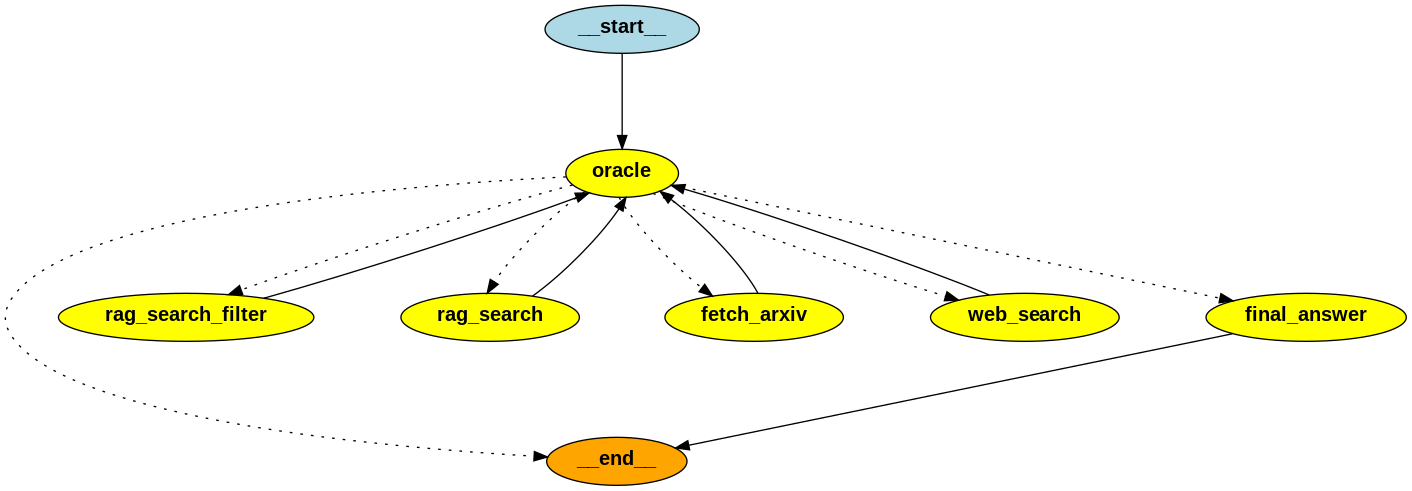

In [49]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [57]:
out = runnable.invoke({
    "input": "tell me something interesting about dogs",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'interesting facts about dogs'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'interesting facts about dogs'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'interesting facts about dogs'}, log="Title: CALYPSO: LLMs as Dungeon Masters' Assistants\nContent: The blink dogs are canine creatures, about the size of a large dog. Their fur is a mottled grey and white colour, and their eyes flash yellow when they use their supernatural ability to blink in and out of ex- istence. They are surprisingly fast despite their size, and can easily keep up with most horses. In terms of behavior, the blink dogs are curious but shy creatures who prefer to avoid contact with other creatures un- less absolutely necessary. If threatened, they will use their blinking power to confuse and disorientate their opponents before attacking with a pack mentality. The blink dogs of this forest 

Let's create a function to consume the agent output and format it into our report:

In [58]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [59]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Dogs are fascinating creatures that have been companions to humans for thousands of years. They are not only beloved pets but also possess unique traits and abilities that make them stand out in the animal kingdom.

RESEARCH STEPS
--------------
- Conducted a specialist search on interesting facts about dogs using a research tool.
- Performed a web search to gather general knowledge and fun facts about dogs.
- Compiled information from various sources to provide a comprehensive overview.

REPORT
------
Dogs, scientifically known as Canis lupus familiaris, are direct descendants of wolves and share many characteristics with their wild ancestors. Despite their domestication, all dogs, regardless of breed, belong to the same species. This evolutionary background contributes to their diverse range of behaviors and physical traits.

One of the most intriguing aspects of dogs is their ability to understand human emotions and gestures. They have coevolved with human

Now let's try with an on-topic question on AI.

In [60]:
out = runnable.invoke({
    "input": "tell me about AI",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'AI overview'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'AI overview'}, log='Title: Conceptual Framework for Autonomous Cognitive Entities\nContent: 5 5 # The field of cybersecurity offers more direct inspiration through layered models like the "Defense in Depth" frame- work [13]. This advocates protecting systems through nested layers encompassing physical security, network security, host security, application security, and data se- curity. The principles of privileged separation and hier- archical control in Defense in Depth informed the ACE Fig. 2. OSI Model , , os , , Shapiro, et al. # frameworkâ s approach. ACE differs from these models by centering layers around cognitive faculties like plan- ning, task switching, and metacognition. While drawing lessons from prior layered architectures, ACE

In [61]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Artificial Intelligence (AI) is a rapidly evolving field that encompasses the development of systems capable of performing tasks that typically require human intelligence. This includes areas such as learning, reasoning, problem-solving, perception, and language understanding.

RESEARCH STEPS
--------------
- Conducted a specialist search using the RAG search tool to gather detailed insights on AI.
- Performed a web search to obtain general information and current trends related to AI.
- Utilized the RAG search filter to delve deeper into specific AI frameworks and concepts.

REPORT
------
AI has become a cornerstone of modern technology, influencing various sectors from healthcare to finance, and even entertainment. At its core, AI involves creating algorithms and models that enable machines to mimic cognitive functions such as learning and problem-solving. One of the key frameworks in AI is the Conceptual Framework for Autonomous Cognitive Entities (ACE), w

Let's ask about RAG specifically.

In [62]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log="Title: AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation\nContent: Due to the page limit, details of the evaluation, including case studies in three scenarios are in Appendix D. # A2: Retrieval-Augmented Code Generation and Question Answering Retrieval augmentation has emerged as a practical and effective approach for mitigating the intrinsic limitations of LLMs by incorporating external documents. In this section, we employ AutoGen to build a Retrieval-Augmented Generation (RAG) system (Lewis et al., 2020; Parvez et al., 2021) named Retrieval-augmented Chat. The system consists of two agents: a Retrieval-augmented User Proxy agent and a Retri

In [63]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an innovative approach in the field of artificial intelligence that enhances the capabilities of generative models by integrating external information sources. This technique is particularly useful in improving the accuracy and reliability of AI-generated content.

RESEARCH STEPS
--------------
- Conducted a specialist search using the RAG search tool to gather detailed information on Retrieval-Augmented Generation.
- Performed a web search to obtain general knowledge and definitions from reputable sources.
- Retrieved the abstract of a relevant ArXiv paper to understand the practical applications of RAG.

REPORT
------
Retrieval-Augmented Generation (RAG) is a method designed to optimize the output of large language models (LLMs) by incorporating information from external knowledge bases. This approach addresses the intrinsic limitations of LLMs, such as their reliance on pre-existing data and potential inaccuracies, b

---